In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier 
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.ensemble import BaggingRegressor, BaggingClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.metrics import SCORERS

import seaborn as sns
sns.set(rc={'figure.figsize':(6,6)}) 
import warnings
warnings.simplefilter("ignore")

%matplotlib inline

In [8]:
from mlxtend.regressor import StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.ensemble import BaggingRegressor, BaggingClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import ExtraTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, AdaBoostClassifier

from xgboost import XGBRegressor, XGBClassifier


In [9]:
estimator_bagging  = BaggingClassifier(n_estimators=5, random_state=42) #  DTs
estimator_randomforest = RandomForestClassifier(n_estimators=5, random_state=42)
estimator_adaboost = AdaBoostClassifier(n_estimators=5, random_state=42)
estimator_bagging_10 = BaggingRegressor(n_estimators=10)
estimator_bagging_100 = BaggingRegressor(n_estimators=100)
estimator_randomforest = RandomForestRegressor(n_estimators=100)
estimator_bagging_elnet = BaggingRegressor(n_estimators=100, 
                                           base_estimator=ElasticNet())
estimator_bagging_random_tree = BaggingRegressor(n_estimators=100,
                                    base_estimator=ExtraTreeRegressor())
estimator_adaboost = AdaBoostRegressor(n_estimators=100)
estimator_xgboost = XGBRegressor(n_estimators=500)

In [10]:
compas = pd.read_csv("Compas.csv")

In [18]:
Pred = compas.drop(['Unnamed: 0', 'id', 'first', 'last', 'age', 'age_cat', 
       'juv_fel_count', 'juv_misd_count', 'juv_other_count',
       'priors_count',  'is_violent_recid', 'v_decile_score',"score_text",
       'v_score_text', 'decile_score.1'], axis =1)

Pred = Pred[(Pred.is_recid != -1)]
Pred = pd.get_dummies(Pred)
Pred = Pred.rename(columns ={'race_African-American':"race_African_American", 'race_Native American': "race_Native_American"})
Pred = Pred[(Pred.race_Caucasian == True) | (Pred.race_African_American == True)]
Pred = Pred.drop(['race_Asian','race_Caucasian', 'race_Hispanic', 'race_Native_American','race_Other'], axis =1)
Pred = Pred[Pred.sex_Female == 1].drop(["sex_Female", "sex_Male"], axis =1)

Pred.head()

PredBl = Pred[(Pred.race_African_American == True)]
PredBl = PredBl.drop("race_African_American", axis = 1)

targetvariable = "is_recid"
independentvariables = PredBl.drop(columns=[targetvariable]).columns

from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()

tree.fit(PredBl[independentvariables], PredBl[targetvariable])

TreeAccuracyDecileScoreBlack = cross_val_score(tree, PredBl[independentvariables],
                PredBl[targetvariable], scoring="accuracy", 
                cv=3).mean()

def evaluate_modelBl(estimator):
    cv_results = cross_validate(estimator,
                    X = PredBl[independentvariables],
                    y = PredBl[targetvariable],
                    scoring="accuracy",
                          n_jobs=-1, cv=3,
                     return_train_score=True)
    return pd.DataFrame(cv_results).abs().mean().to_dict()

def display_results(results):
    results_df  = pd.DataFrame(results).T
    results_cols = results_df.columns
    for col in results_df:
        results_df[col] = results_df[col].apply(np.mean)
    return results_df

resultsBl = {}

resultsBl["Bagging"] = evaluate_modelBl(estimator_bagging)
resBl = display_results(resultsBl).iloc[[0][0]].test_score

PredWh = Pred[(Pred.race_African_American == False)]
PredWh = PredWh.drop("race_African_American", axis = 1)
targetvariable = "is_recid"
independentvariables = PredWh.drop(columns=[targetvariable]).columns

tree.fit(PredWh[independentvariables], PredWh[targetvariable])


TreeAccuracyDecileScoreWhite = cross_val_score(tree, PredWh[independentvariables],
                                           PredWh[targetvariable], scoring="accuracy", 
                                           cv=3).mean()

def evaluate_modelWh(estimator):
    cv_results = cross_validate(estimator,
                    X = PredWh[independentvariables],
                    y = PredWh[targetvariable],
                    scoring="accuracy",
                          n_jobs=-1, cv=3,
                     return_train_score=True)
    return pd.DataFrame(cv_results).abs().mean().to_dict()

resultsWh = {}
resultsWh["Bagging"] = evaluate_modelWh(estimator_bagging)
resWh = display_results(resultsWh).iloc[[0][0]].test_score


BaggDiffAcc = round(abs(resWh- resBl) *100,2)

TreeDiffAcc = round(abs(TreeAccuracyDecileScoreWhite - TreeAccuracyDecileScoreBlack) *100,2)


[TreeAccuracyDecileScoreWhite,TreeAccuracyDecileScoreBlack]

print(f"According to Decision Tree, Decile Score for White Criminals is {TreeDiffAcc}% more accurate than Black Criminals")

print(f"According to the Bagging Tree, Decile Score for White Criminals is {BaggDiffAcc}% more accurate than Black Criminals")

Treeresults = pd.DataFrame({"Race": ["Black Women", "White Women"],
                   'Accuracy': [TreeAccuracyDecileScoreBlack, TreeAccuracyDecileScoreWhite],
                   })
                   

Baggresults = pd.DataFrame({"Race": ["Black Women", "White Women"],
                   'Accuracy': [resBl, resWh],
                   })

According to Decision Tree, Decile Score for White Criminals is 3.82% more accurate than Black Criminals
According to the Bagging Tree, Decile Score for White Criminals is 3.72% more accurate than Black Criminals


[Text(0, 0.5, 'Accuracy'),
 Text(0.5, 0, 'Race'),
 Text(0.5, 1.0, ' Decile Score Accuracies By Race')]

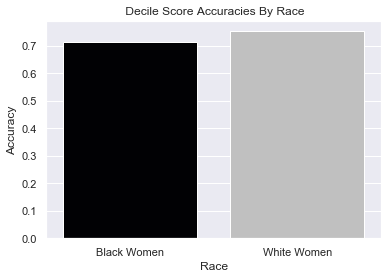

In [19]:
colors = [ "#000005","#C0C0C0" ]
customPalette = sns.set_palette(sns.color_palette(colors))
sns.set_palette(sns.color_palette(colors))

fig = sns.barplot(data = Treeresults,x = "Race", y= "Accuracy", palette=customPalette)
fig.set(xlabel='Race', ylabel='Accuracy', Title = " Decile Score Accuracies By Race")

[Text(0, 0.5, 'Accuracy'),
 Text(0.5, 0, 'Race'),
 Text(0.5, 1.0, ' Decile Score Accuracies By Race')]

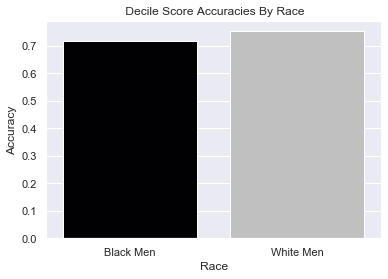

In [14]:
colors = [ "#000005","#C0C0C0" ]
customPalette = sns.set_palette(sns.color_palette(colors))
sns.set_palette(sns.color_palette(colors))

fig = sns.barplot(data = Baggresults,x = "Race", y= "Accuracy", palette=customPalette)
fig.set(xlabel='Race', ylabel='Accuracy', Title = " Decile Score Accuracies By Race")